In [33]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from scipy.special import xlogy
from sklearn import preprocessing
from scipy.stats import mode
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns


# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

def timer(method):
    def timed(*args, **kw):
        ts = perf_counter()
        result = method(*args, **kw)
        te = perf_counter()
        tlapsed = te-ts
        print(f"{tlapsed//60} mins and {tlapsed%60:0.2f} secs")
        return result
    return timed

In [3]:
# def grierer_meinhardt(U, V, Du, Dv, c1, c2, c3, c4, c5, k, dt, dx, T, sr=5):
#     n = U.shape[0]
#     iters = int(T / dt)
#     for i in tqdm(range(iters)):
#         Lu = Du*lap_neumann(U)/dx/dx
#         Lv = Dv*lap_neumann(V)/dx/dx
#         uc = U[1:-1, 1:-1]
#         vc = V[1:-1, 1:-1]
#         U[1:-1, 1:-1], V[1:-1, 1:-1] =\
#         uc + dt*(Lu + c1 - c2*uc + c3*uc*uc/(1+k*uc*uc)/vc),\
#         vc + dt*(Lv + c4*uc*uc - c5*vc)
#         for u in (U, V):
#             u[0, :] = u[1, :]
#             u[-1, :] = u[-2, :]
#             u[:, 0] = u[:, 1]
#             u[:, -1] = u[:, -2]
#     return U, V

s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0):
    np.random.seed(seed=5000000)
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.1)*100
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.01)).real*10

    binarized1 = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels1 = ndimage.label(binarized1, structure=s)
    binarized2 = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels2 = ndimage.label(binarized2, structure=s)
    if labels1[1] > labels2[1]:
        bins, edges = np.histogram(labels1[0], bins=labels1[1])
        return bins[1:]

    # Try inversed region
    if labels2[1] > 1:
        bins, edges = np.histogram(labels2[0], bins=labels2[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

def bulkrun(f, k, n=250, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    u_median, v_median = np.zeros_like(f), np.zeros_like(f)
    u_std, v_std = np.zeros_like(f), np.zeros_like(f)
    for index, F in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, F, k[index], T)
        obj_u = calc_objects(u)
        obj_v = calc_objects(v)
        
        u_median[index] = np.median(obj_u)
        u_std[index] = np.std(obj_u)
        v_median[index] = np.median(obj_v)
        v_std[index] = np.std(obj_v)
    return (u_median, v_median), (u_std, v_std)

def shannon_entropy(inp):
    p = gaussian_kde(inp)
    return quad(lambda x: -p.pdf(x)*p.logpdf(x), -1000, 10000)[0]

def bulk_entropy(f, k, n=200, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros_like(f)
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        obj_u = calc_objects(u)
        if obj_u.any():
            outp[index] = shannon_entropy(obj_u)
    return outp

def bulk_entropy1d(f, k, n=250, T=20000):
    iters = len(f)
    
    outp = np.zeros_like(f)
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        obj_u = calc_objects(u)
        if obj_u.any():
            outp[index] = shannon_entropy(obj_u)
    return outp


def testyo(f, k, n=150, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros_like(f)
    print("F     k")
    for index, F in tqdm(np.ndenumerate(f), total=iters):
        print(f"{F}   {k[index]}   {index}")
    return 0



@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc

def convolution(mat, kernel, rep=1):
    for _ in range(rep):
        mat = convolve(mat, kernel, mode='wrap')
    return mat


In [ ]:
f = np.linspace(0.001, 0.06, 100)
k = np.linspace(0.04, 0.07, 100)

outp = bulk_entropy(f, k)

plt.figure(figsize=(15,15))
plt.imshow(outp.T, cmap='jet', origin='lower', interpolation='lanczos', extent=(0.04, 0.07, 0.01, 0.06))
plt.xlabel("k")
plt.ylabel("F")
plt.title("Shannon entropy")
plt.colorbar()
plt.show()

In [ ]:
# Transition 1
# A F=0.0271360 k=0.06141
# D F=0.0238191 k=0.05869347
f = np.linspace(0.0238191, 0.0271360, 100)
k = np.linspace(0.05869347, 0.06141, 100)

outp = bulk_entropy(f, k)

plt.figure(figsize=(15,15))
plt.imshow(outp.T, cmap='jet', origin='lower', interpolation='lanczos', extent=(k[0], k[-1], f[0], f[-1]))
plt.xlabel("k")
plt.ylabel("F")
plt.title("Shannon entropy")
plt.colorbar()
plt.show()

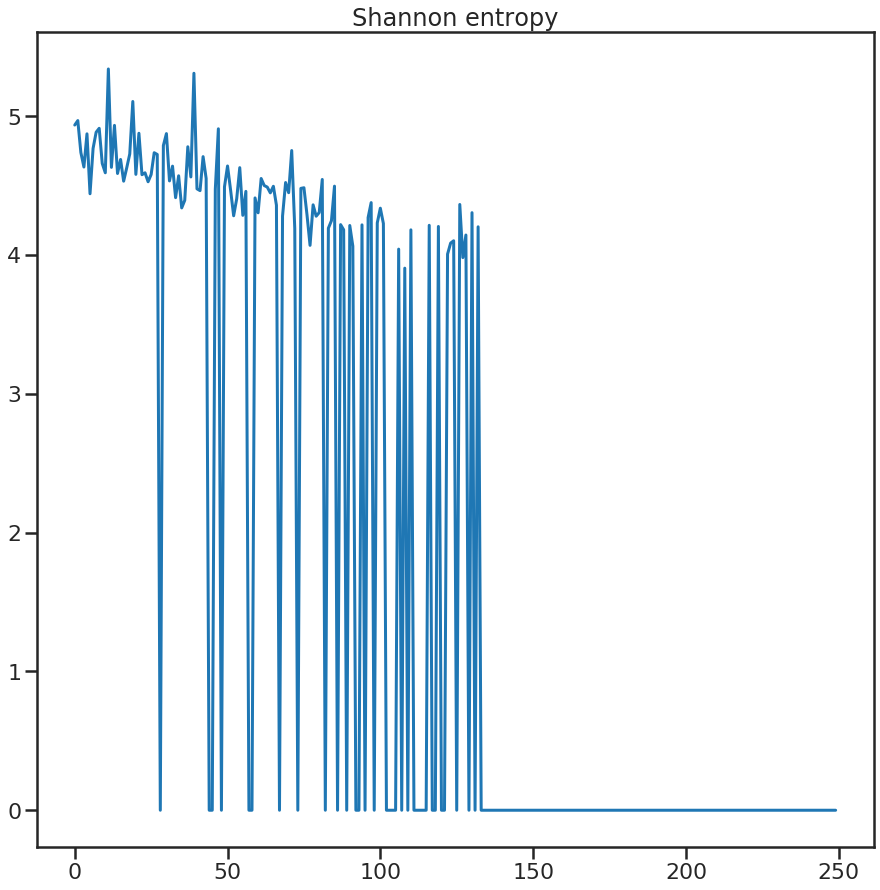

In [5]:
f = np.linspace(0.0238191, 0.0271360, 250)
k = np.linspace(0.05869347, 0.06141, 250)

outp = bulk_entropy1d(f, k)

plt.figure(figsize=(15,15))
plt.plot(outp)
plt.title("Shannon entropy")
plt.show()

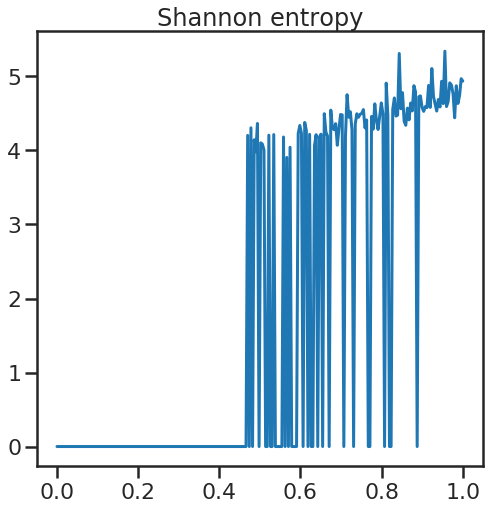

In [53]:
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0, 1, len(outp)),outp[::-1])
plt.title("Shannon entropy")
plt.show()

In [6]:
ds2 = np.loadtxt('ds2')

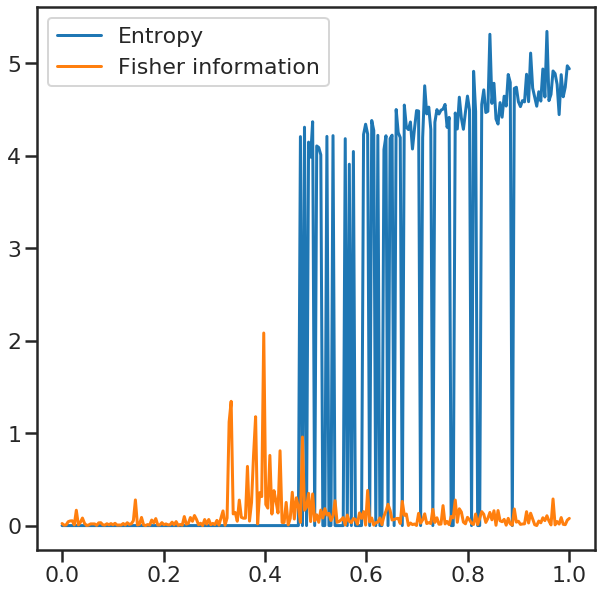

In [56]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0, 1, len(outp)),outp[::-1], label='Entropy')
plt.plot(np.linspace(0, 1, len(outp)),np.abs(ds2)[::-1], label='Fisher information')
plt.legend()
plt.show()

In [40]:
np.savetxt('entropy1', outp)

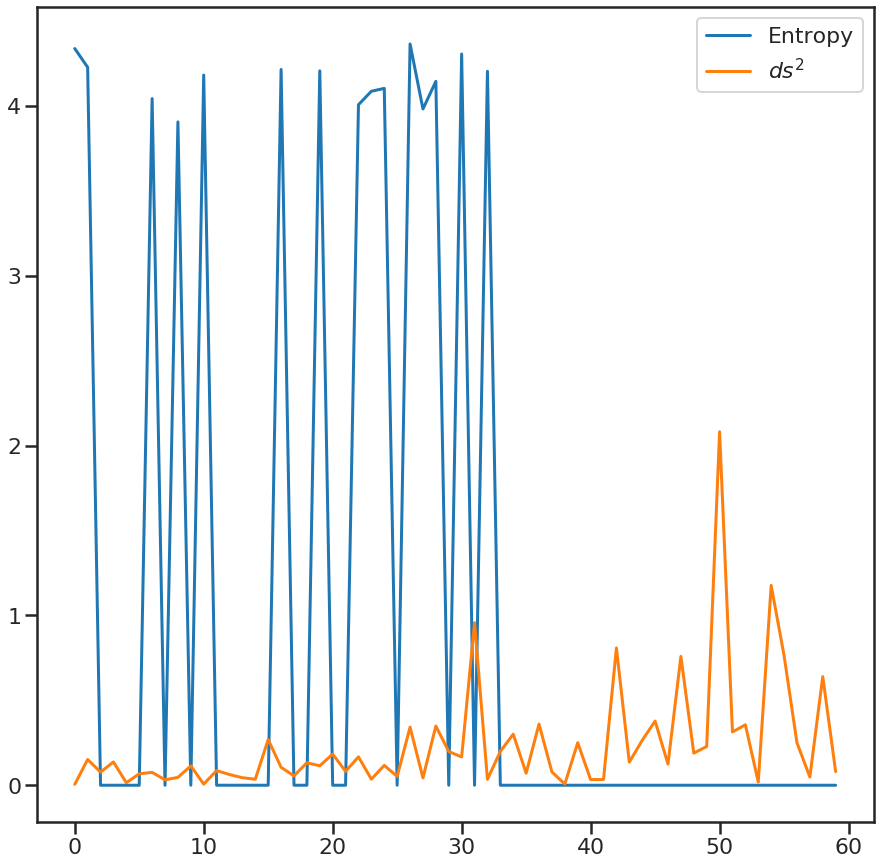

In [13]:
plt.figure(figsize=(15,15))
plt.plot(outp[100:160], label='Entropy')
plt.plot(np.abs(ds2[100:160]), label='$ds^2$')
plt.legend()
plt.show()

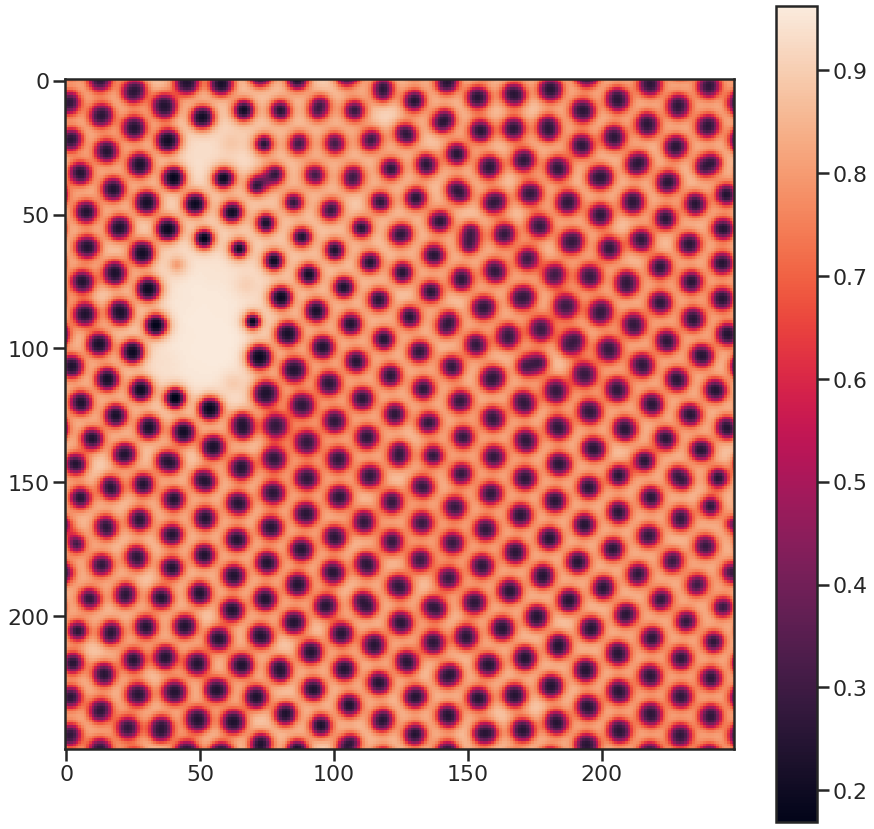

In [16]:
plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[133], k[133], 20000)[0])
plt.colorbar()
plt.show()

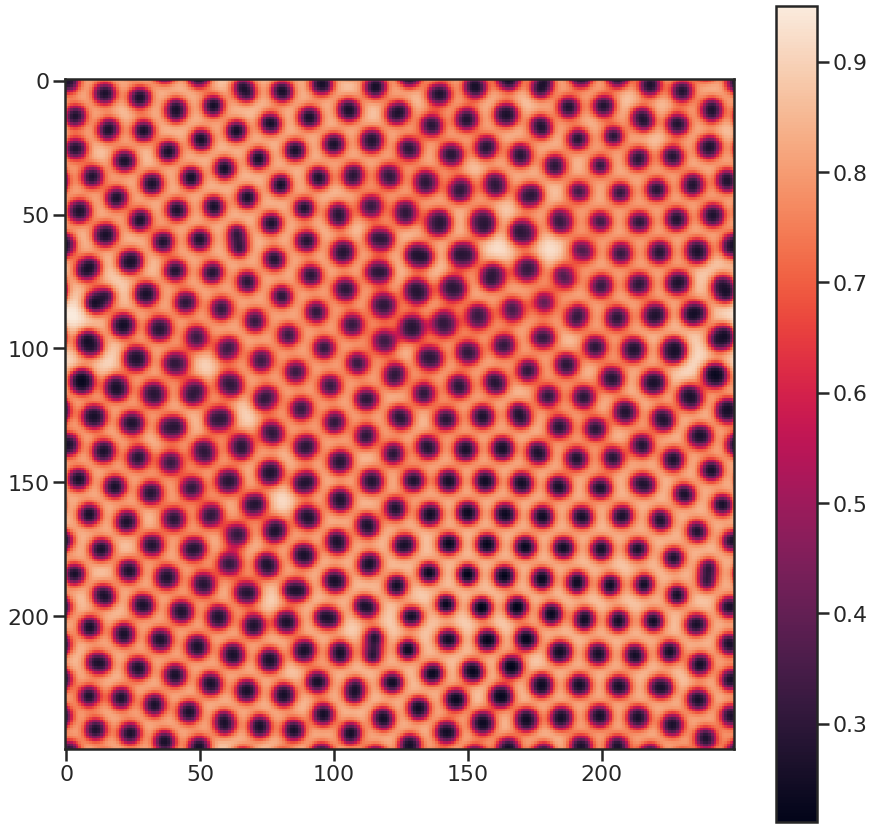

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[136], k[136], 20000)[0])
plt.colorbar()
plt.show()

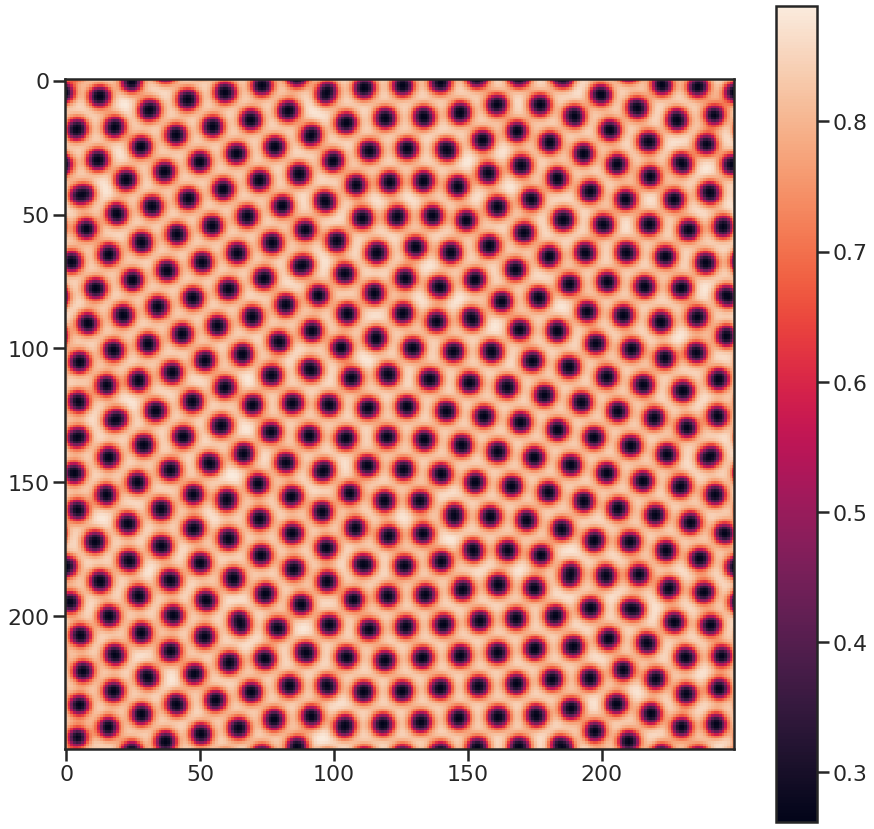

In [31]:
plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[249], k[249], 20000)[0])
plt.colorbar()
plt.show()

In [32]:
gifding = np.zeros((250, 250, 250))
for i in tqdm(range(250)):
    gifding[i] = gscott(250, f[i], k[i], 20000)[0]
np.save('gifje', gifding)

In [27]:
a[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

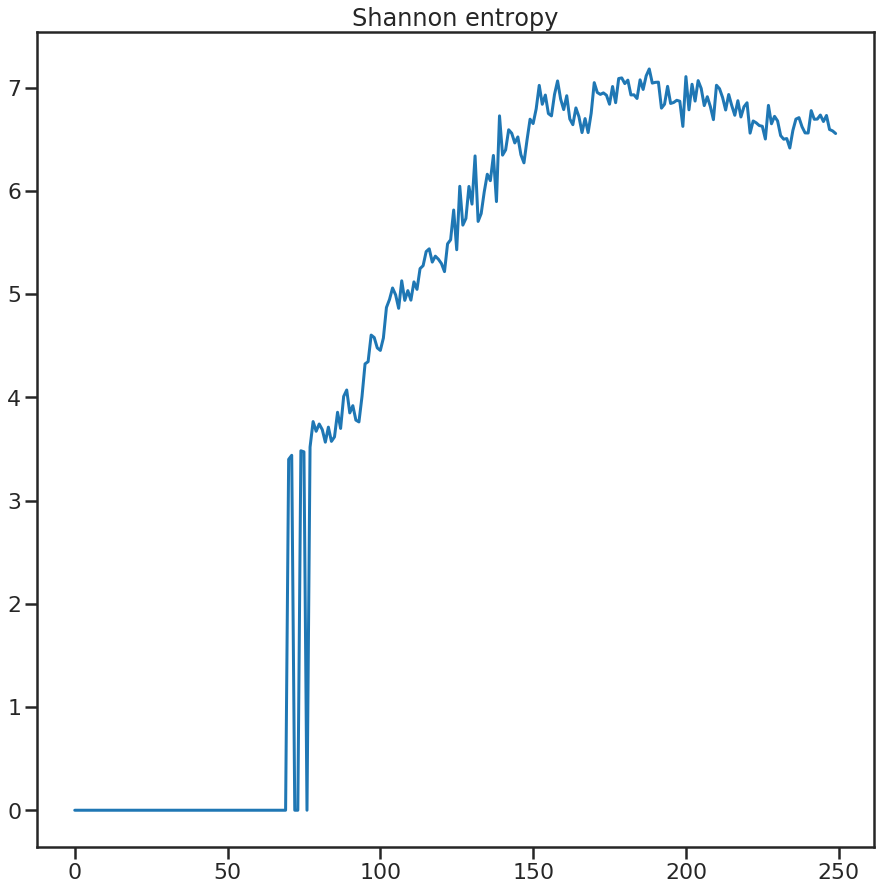

In [34]:
k = np.linspace(0.0652, 0.0632, 250)
f = np.linspace(0.0395, 0.04228, 250)

outp2 = bulk_entropy1d(f, k)

plt.figure(figsize=(15,15))
plt.plot(outp2)
plt.title("Shannon entropy")
plt.show()

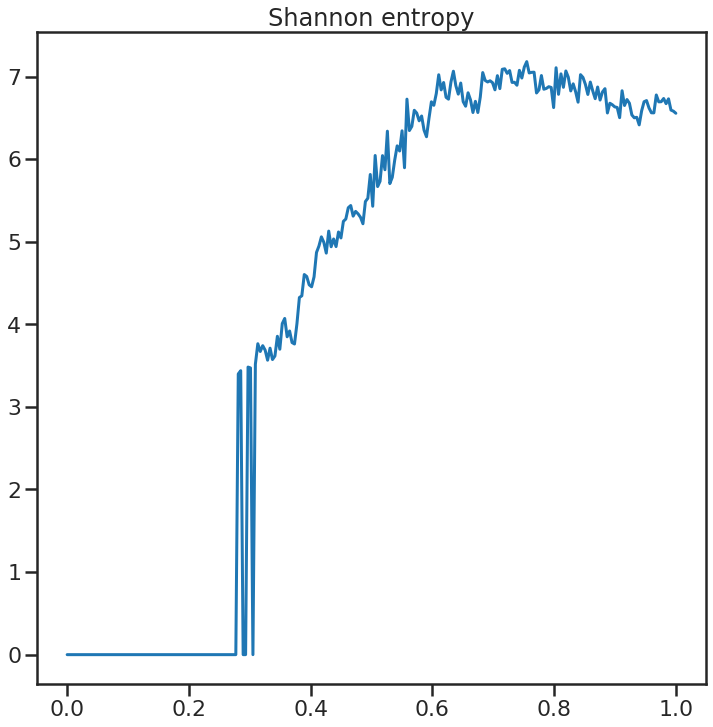

In [57]:
plt.figure(figsize=(12,12))
plt.plot(np.linspace(0, 1, len(outp2)),outp2)
plt.title("Shannon entropy")
plt.show()

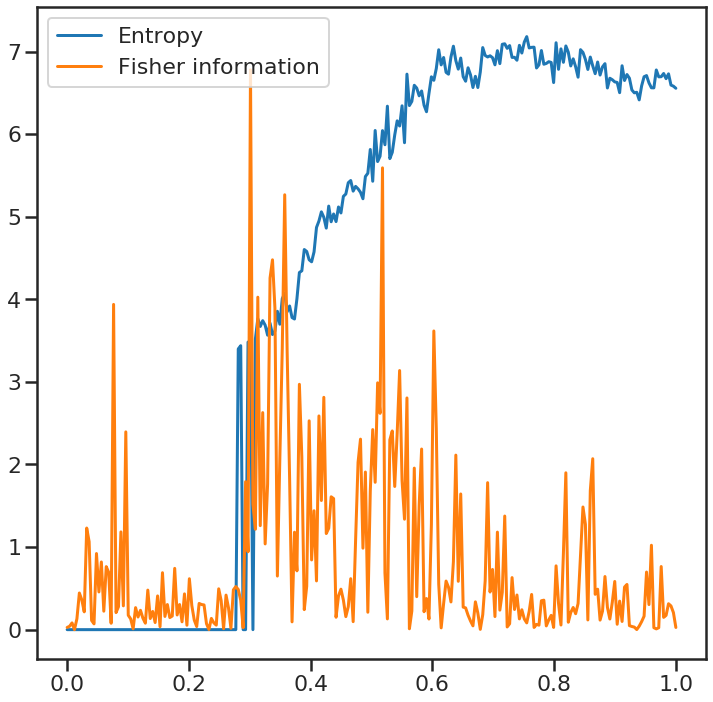

In [59]:
ds2v2 = np.loadtxt('ds2v2')*480
plt.figure(figsize=(12,12))
plt.plot(np.linspace(0, 1, len(outp2)),outp2, label='Entropy')
plt.plot(np.linspace(0, 1, len(outp2)),ds2v2, label='Fisher information')
plt.legend()
plt.show()

In [60]:
k = np.linspace(0.0652, 0.0632, 250)
f = np.linspace(0.0395, 0.04228, 250)

gifding = np.zeros((250, 250, 250))
for i in tqdm(range(250)):
    gifding[i] = gscott(250, f[i], k[i], 30000)[0]
np.save('gifje2', gifding)

In [49]:
np.savetxt('entropy2', outp2)

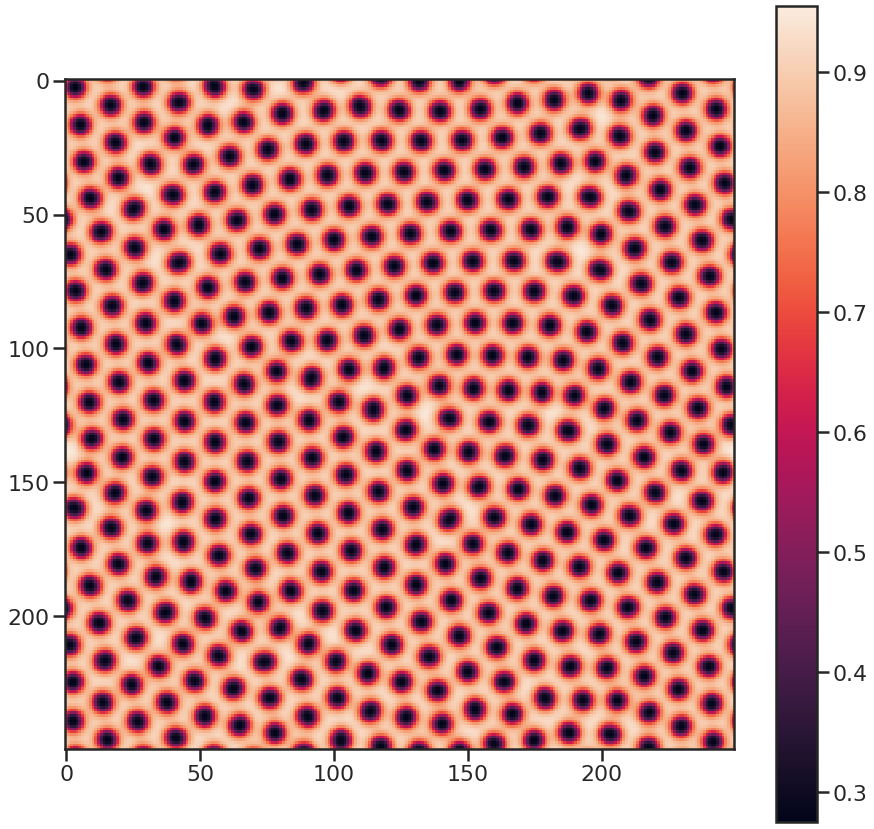

In [63]:
plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[0], k[0], 50000)[0])
plt.colorbar()
plt.show()

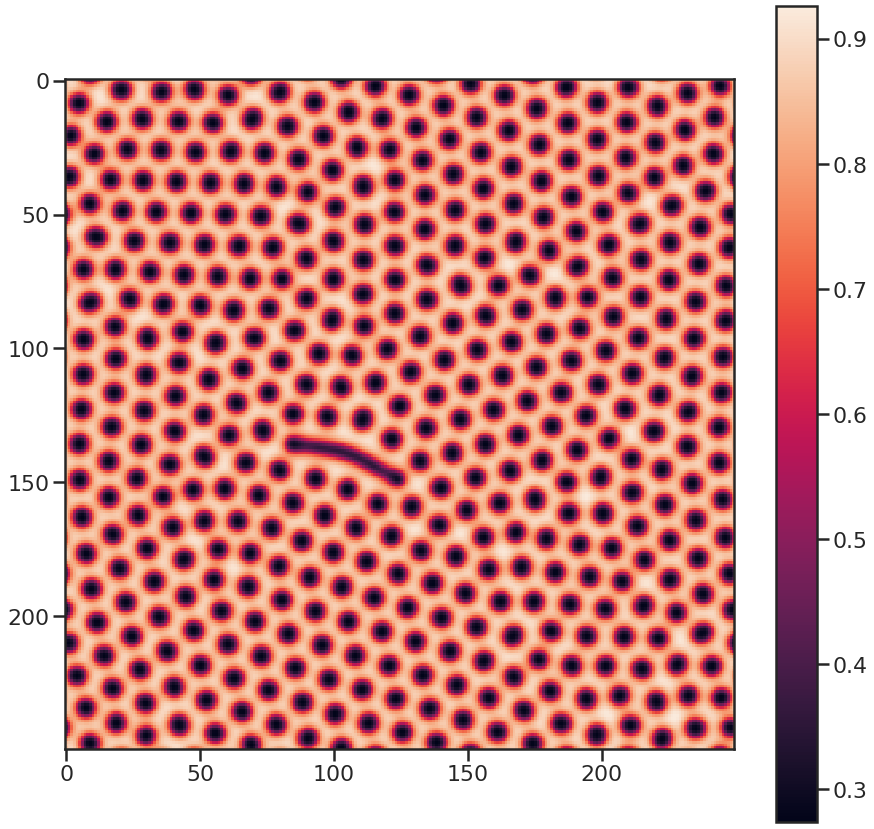

In [69]:
plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[70], k[70], 50000)[0])
plt.colorbar()
plt.show()

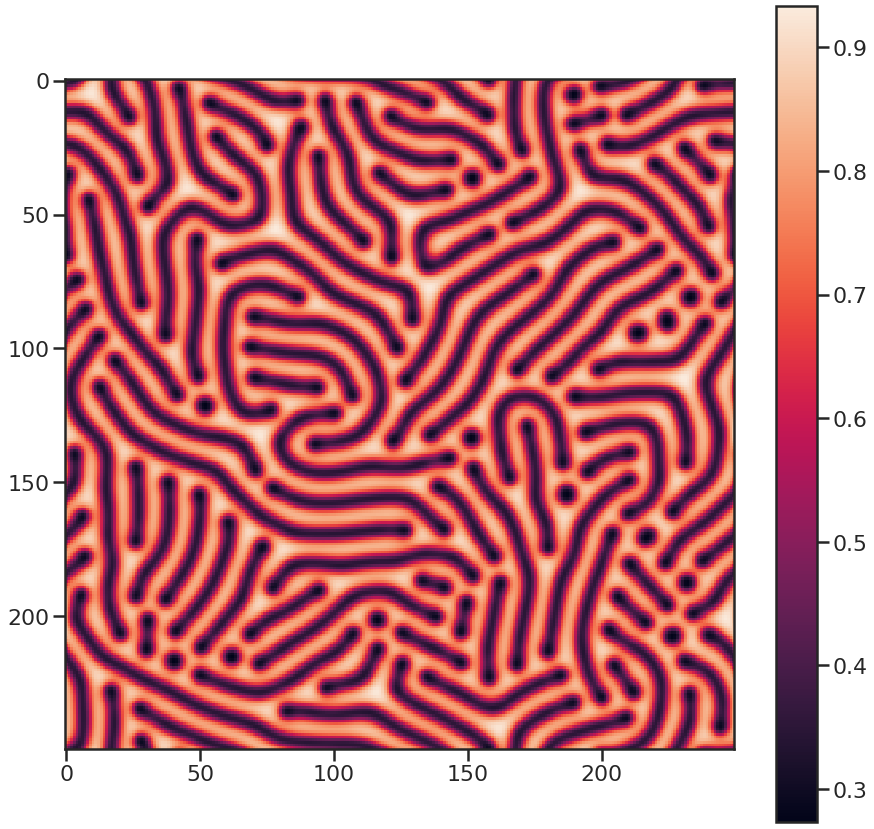

In [71]:
plt.figure(figsize=(15,15))
plt.imshow(gscott(250, f[200], k[200], 50000)[0])
plt.colorbar()
plt.show()